Andres Castellano, Snehlata Singh, Roberto Rivera

## Framing the Problem

We are asked to determine the natural log of the sum of all transactions per user. Presumably, we will be provided a data set with a number of features and we will use those features to predict how much money a user will spend on the site. Then G Stores will use the analysis to develop a marketing strategy and optimize its sales. 

### Problem Details

Moreover, this is a supervised learning problem as we will be analyzing labeled data. Specifically, this is a regression problem since we are asked to calculate a value from a set of labeled data. There does not seem to be a need to analyzea continuous flow of data. The data will come in a fixed size file and therefore this should be a batch regression task.

### Error Metric

<h3><center>$ RMSE = \sqrt{\frac{1}{m}\sum_{n=1}^{m}[h(x{(i)}-y{(i)}]^2 }$</center></h3>

***


## The Data

First we will import some libraries in anticipation of our requirements.

In [0]:

import pandas as pd # Pandas Library for Data Analysis
import numpy as np # Numerical Python library for Matrix Manipulation

In [0]:
# Code to read csv file into Colaboratory:

!pip install -U -q PyDrive #Uses 'pip installer' to install PyDrive, a package for working with Google Drive. 

#The next four lines import several commands from pydrive, this will allows us to log into and read files from google drive into the program

from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1DwWjoqzMr61s3DaoiCB2cDm1iBrs5s8z' #Shareable link (Externally Provided)

fluff, id = link.split('=')
# print (id) # Debugging line
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Filename.csv')
train_set = pd.read_csv('Filename.csv') #loads data into a pandas DataFrame

link = 'https://drive.google.com/open?id=1MtQGaO0otJ5ykJg64KPLFaOOu3aUURHd' #Shareable link(Externally Provided)

fluff, id = link.split('=')
# print (id) 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Filename.csv')
test_set = pd.read_csv('Filename.csv') #loads data into a pandas DataFrame
#test_set.info()

## What does the data look like?

Pandas provides several methods to visualize the data, in this section we will use the info(), head(), describe() and plot() methods to get an understanding of how the data is distributed, what data types are included and what values are missing if any.


###  head()
We use the .head() method to visualize the top 5 rows of the data frame along all the columns.

In [141]:
train_set.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,Western Europe,1.0,1,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset,Cupertino,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,NaN,2,NaN,2.0,2.0,28.0,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercab

It is clear that a lot of columns are missing information that allegedely was included in a different version of the data set. The following code will remove those columns.

In [0]:
# This data is very noise and needs to be cleaned up removing a bunch of columns whose data is not included in demo dataset

list_na = ['device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo',
           'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors',
           'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro', 'geoNetwork.networkLocation', 'geoNetwork.region',
           'trafficSource.adwordsClickInfo.criteriaParameters','geoNetwork.networkDomain', 'device.operatingSystem',] #creates a list of column names to be removed (.drop())
train_set = train_set.drop(list_na, axis = 1) # Drops empty columns from train_set
test_set = test_set.drop(list_na, axis = 1) # Drops empty columns from test_set


### info() 
We use the info() method to get a quick description of the data,
 for example the total number of roads and each attribute's type 
 and number of non-null values. 

In [143]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 38 columns):
channelGrouping                                 20000 non-null object
customDimensions                                20000 non-null object
date                                            20000 non-null int64
fullVisitorId                                   20000 non-null uint64
hits                                            20000 non-null object
socialEngagementType                            20000 non-null object
visitId                                         20000 non-null int64
visitNumber                                     20000 non-null int64
visitStartTime                                  20000 non-null int64
device.browser                                  20000 non-null object
device.deviceCategory                           20000 non-null object
device.isMobile                                 20000 non-null bool
geoNetwork.city                                 20000 non

### fillna()
We need to replace null values from transaction totals columns with zero (0). We choose zero (0) versus other values because impting the median for instance would introduce bias into the algorithm. In addition, notice that there are a lot more null data points from transaction totals (-20000 null to 639 non null.) If we chose to only use those points for which there are transaction totals, we would have very little data to make the program useful. For this project we will assume that those data points for which there is no transacitno totals, are customers who in fact browsed the online catalog but did not make a purchase. This hypothesis is supported by the total.Transactions column.
We will use the fillna() method to replace NaN values with zeros. 

In [0]:


train_set['totals.transactionRevenue'].fillna(0, inplace=True)
train_set['totals.totalTransactionRevenue'].fillna(0, inplace=True)
train_set['totals.transactions'].fillna(0, inplace=True)

test_set['totals.totalTransactionRevenue'].fillna(0, inplace=True)
test_set['totals.transactionRevenue'].fillna(0, inplace=True)
test_set['totals.transactions'].fillna(0, inplace=True)


### describe()

The describe method provides a basic statistical summary. It calculate basic descriptive statistics such as mean, variance, min-max and quartile summaries.

In [145]:
train_set.describe()

,date,fullVisitorId,visitId,visitNumber,visitStartTime,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adwordsClickInfo.page
count,2.000000e+04,2.000000e+04,2.000000e+04,20000.000000,2.000000e+04,9873.0,20000.000000,15088.0,19999.000000,9120.000000,10101.000000,2.000000e+04,2.000000e+04,20000.000000,20000.0,630.000000
mean,2.017041e+07,4.533406e+18,1.498277e+09,2.264200,1.498277e+09,1.0,4.794450,1.0,3.971549,4.456140,264.244629,1.233455e+06,1.049569e+06,0.010200,1.0,1.023810
std,4.737638e+03,3.067707e+18,1.565797e+07,7.876636,1.565797e+07,0.0,9.080243,0.0,6.498605,12.593541,459.176173,2.690911e+07,1.985998e+07,0.104864,0.0,0.172159
min,2.016090e+07,8.864048e+13,1.472799e+09,1.000000,1.472800e+09,1.0,1.000000,1.0,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,1.0,1.000000
25%,2.017020e+07,1.618305e+18,1.486118e+09,1.000000,1.486118e+09,1.0,1.000000,1.0,1.000000,1.000000,35.000000,0.000000e+00,0.000000e+00,0.000000,1.0,1.000000
50%,2.017062e+07,4.446795e+18,1.498247e+09,1.000000,1.498247e+09,1.0,2.000000,1.0,2.000000,1.000000,94.000000,0.000000e+00,0.000000e+00,0.000000,1.0,1.000000
75%,2.017113e+07,7.218982e+18,1.512038e+09,1.000000,1.512038e+09,1.0,5.000000,1.0,4.000000,1.000000,270.000000,0.000000e+00,0.000000e+00,0.000000,1.0,1.000000
max,2.018042e+07,9.999250e+18,1.523862e+09,401.000000,1.523862e+09,1.0,229.000000,1.0,165.000000,96.000000,5553.000000,2.103690e+09,1.171470e+09,3.000000,1.0,3.000000


### Preliminary Data Cleaning

Columns totals.bounces and totals.newVisits, totals.visits do not provide any meaningful information, colum trafficSource.adwordsClickinfo.page is ddificult to interpret. We will remove the entirety of these columns as we are unsure what the underlying principles are or how to interpret them.

In [0]:

list_drop = ['totals.bounces', 'totals.newVisits', 'totals.visits', 'trafficSource.adwordsClickInfo.page','trafficSource.adwordsClickInfo.adNetworkType',
             'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.keyword', 'trafficSource.referralPath']
train_set = train_set.drop(list_drop, axis=1)
test_set = test_set.drop(list_drop, axis=1)

# Visualizing The Data

### Scatter Plots

Let's Review what the data looks like using the matplot Python library.

In [0]:

%matplotlib inline 
import matplotlib.pyplot as plt 

In [148]:
train_set.head() # What does the data look like after removing some columns and replacing Nan values.

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.subContinent,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.medium,trafficSource.source
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,desktop,False,not available in demo dataset,Europe,Germany,Western Europe,1,1.0,1.0,NaN,0.0,0.0,0.0,NaN,(not set),NaN,organic,google
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,desktop,False,Cupertino,Americas,United States,Northern America,2,2.0,2.0,28.0,0.0,0.0,0.0,NaN,(not set),NaN,referral,sites.google.com
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,mobile,True,not available in demo dataset,Americas,United States,Northern America,2,2.0,1.0,38.0,0.0,0.0,0.0,NaN,(not set),True,(none),(direct)
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,1508169851,1,1508169851,Chrome,desktop,False,not available in demo dataset,Asia,Turkey,Western Asia,2,2.0,1.0,1.0,0.0,0.0,0.0,NaN,(not set),NaN,organic,google
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,1508190552,1,1508190552,Chrome,desktop,False,not available in demo dataset,Americas,Mexico,Central America,2,2.0,1.0,52.0,0.0,0.0,0.0,NaN,(not set),NaN,organic,google


Let's use some exploratory data anlysis with totals.hits vs totals.transactionRevenue

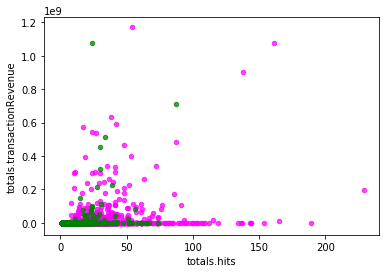

In [149]:
ax1 = train_set.plot(kind='scatter', x='totals.hits',y='totals.transactionRevenue', legend=True, color='magenta', alpha=0.75)
ax2 = test_set.plot(kind='scatter', x='totals.hits',y='totals.transactionRevenue', legend=True, color='green', alpha=0.75, ax=ax1)

In [150]:
train_set.corr() # Tentative Correlation matrix

,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.isMobile,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions
date,1.000000,-0.005764,0.834258,0.010696,0.834258,0.121160,-0.026584,-0.025227,-0.040335,-0.010353,-0.020200,-0.017714,-0.014363
fullVisitorId,-0.005764,1.000000,0.003972,-0.013907,0.003972,-0.010802,-0.006086,-0.005042,-0.004101,-0.010384,-0.011466,-0.012523,-0.009320
visitId,0.834258,0.003972,1.000000,0.008738,1.000000,0.085367,0.001864,0.000164,-0.037221,-0.024636,-0.023671,-0.022747,-0.018369
visitNumber,0.010696,-0.013907,0.008738,1.000000,0.008738,-0.049448,0.031421,0.032962,0.077545,0.039356,0.009801,0.011616,0.012659
visitStartTime,0.834258,0.003972,1.000000,0.008738,1.000000,0.085367,0.001864,0.000164,-0.037221,-0.024636,-0.023671,-0.022747,-0.018369
device.isMobile,0.121160,-0.010802,0.085367,-0.049448,0.085367,1.000000,-0.065366,-0.067918,-0.126149,-0.055015,-0.025789,-0.029310,-0.044037
totals.hits,-0.026584,-0.006086,0.001864,0.031421,0.001864,-0.065366,1.000000,0.981092,0.702938,0.551340,0.232754,0.262387,0.353199
totals.pageviews,-0.025227,-0.005042,0.000164,0.032962,0.000164,-0.067918,0.981092,1.000000,0.717817,0.580908,0.239445,0.270128,0.368334
totals.sessionQualityDim,-0.040335,-0.004101,-0.037221,0.077545,-0.037221,-0.126149,0.702938,0.717817,1.000000,0.423240,0.254497,0.243375,0.429527
totals.timeOnSite,-0.010353,-0.010384,-0.024636,0.039356,-0.024636,-0.055015,0.551340,0.580908,0.423240,1.000000,0.115359,0.133322,0.189402


Although relationships aren't too strong, some candidates arise such as page views and hits as it is to be expected. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0fb4ea5400>,
      dtype=object)

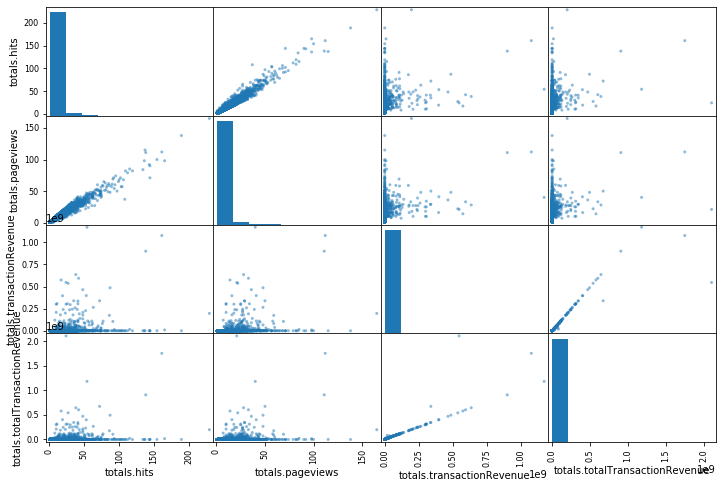

In [151]:
from pandas.plotting import scatter_matrix #imports a scatter_matrix tool to visualize relationships across multiple features.

attributes = ['totals.hits', 'totals.pageviews', 'totals.transactionRevenue', 'totals.totalTransactionRevenue'] # Selects attributes to be plotted on scatter_diagram

scatter_matrix(train_set[attributes], figsize=(12, 8)) # Plots a scatter diagram selecting the attribute list from the train_set DataFrame.

### Visualizing Candidates
From the scatter_matrix, total pageviews came out as a good candidate to predict total revenue. Let's take a closer look using the DataFrame.plot() feature. 

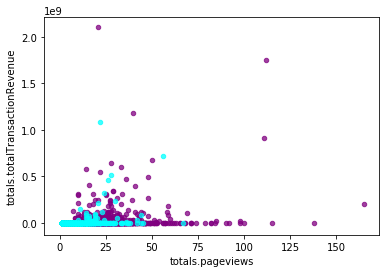

In [152]:
#train_set.plot(kind='scatter', x='totals.pageviews', y='totals.totalTransactionRevenue', alpha=0.75)
ax3 = train_set.plot(kind='scatter', x='totals.pageviews',y='totals.totalTransactionRevenue', legend=True, color='purple', alpha=0.75)
ax4 = test_set.plot(kind='scatter', x='totals.pageviews',y='totals.totalTransactionRevenue', legend=True, color='cyan', alpha=0.75, ax=ax3)

# What about attribute combinations?

It is possible that combinations of multiple attributes is a better predictor than single attributes. For example, hits per visit may be more insightful than just number of hits or number of visits.

In [0]:
# The following four lines of code perform an element wise division of columns total.hits and visitNumber, and totals.hits and totals.pageviews on both the train_set and the test_Set  

train_set['hits_per_visit'] = train_set['totals.hits']/train_set['visitNumber'] 
train_set['hits_per_views'] = train_set['totals.hits']/train_set['totals.pageviews']

test_set['hits_per_visit'] = test_set['totals.hits']/test_set['visitNumber']
test_set['hits_per_views'] = test_set['totals.hits']/test_set['totals.pageviews']


In [154]:
corr_matrix = train_set.corr() # Crates a matrix showing the correlation amongst all variables in the DataFrame
corr_matrix['totals.transactionRevenue'].sort_values(ascending=True) # Sorts the columns in ascending order of Correlation

device.isMobile                  -0.029310
visitStartTime                   -0.022747
visitId                          -0.022747
date                             -0.017714
fullVisitorId                    -0.012523
visitNumber                       0.011616
hits_per_views                    0.052441
hits_per_visit                    0.123294
totals.timeOnSite                 0.133322
totals.sessionQualityDim          0.243375
totals.hits                       0.262387
totals.pageviews                  0.270128
totals.transactions               0.548267
totals.totalTransactionRevenue    0.906034
totals.transactionRevenue         1.000000
Name: totals.transactionRevenue, dtype: float64

### total.pageviews 

From the table above, appears to be a promising attribute to predict total revenue. Let's use the plot() function to visualize the relationship. 

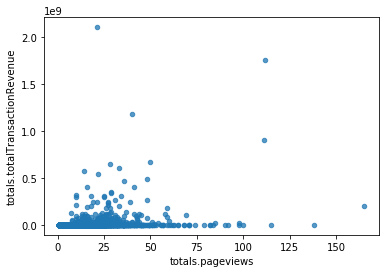

In [155]:
train_set.plot(kind='scatter', x='totals.pageviews', y='totals.totalTransactionRevenue',
              alpha=0.75) #Scatter plot

Finally, let us use the describe() method one last time to ensure we've removed Nan values and Unecessary Columns. 

In [156]:
test_set.describe()

,date,fullVisitorId,visitId,visitNumber,visitStartTime,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,hits_per_visit,hits_per_views
count,2000.0,2.000000e+03,2.000000e+03,2000.000000,2.000000e+03,2000.000000,1999.000000,2000.000000,597.000000,2.000000e+03,2.000000e+03,2000.000000,2000.000000,1999.000000
mean,20180511.0,4.641727e+18,1.526062e+09,2.586000,1.526062e+09,5.063500,3.865433,5.054000,356.514238,2.427605e+06,2.356105e+06,0.015500,4.115931,1.125506
std,0.0,3.085216e+18,2.185853e+04,9.711424,2.185514e+04,8.766749,6.237893,13.764658,527.043185,3.508958e+07,3.473727e+07,0.123561,7.702728,0.257714
min,20180511.0,2.037790e+15,1.526021e+09,1.000000,1.526022e+09,1.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.005181,1.000000
25%,20180511.0,1.717570e+18,1.526045e+09,1.000000,1.526045e+09,1.000000,1.000000,1.000000,74.000000,0.000000e+00,0.000000e+00,0.000000,1.000000,1.000000
50%,20180511.0,4.594328e+18,1.526060e+09,1.000000,1.526060e+09,1.000000,1.000000,1.000000,168.000000,0.000000e+00,0.000000e+00,0.000000,1.000000,1.000000
75%,20180511.0,7.365011e+18,1.526078e+09,2.000000,1.526078e+09,6.000000,4.000000,1.000000,390.000000,0.000000e+00,0.000000e+00,0.000000,3.708333,1.166667
max,20180511.0,9.999790e+18,1.526108e+09,195.000000,1.526108e+09,87.000000,67.000000,94.000000,5268.000000,1.082500e+09,1.076500e+09,1.000000,87.000000,5.200000


# Preparing the data for Machine Learning Algorithms

Since this is a supervised learning problem, we will create copies of our data sets. In one copy, we will remove the feature 'labels' from the data set and in the other one, we will simply copy all those labels.

In [0]:
google = train_set.drop('totals.transactionRevenue', axis=1) # Drops labels from training set and saves the new DataFrame as google
google_labels = train_set['totals.transactionRevenue'].copy() # Creates a DataFrame containing the feature labels as google_labels

# Handling Qualitative Data

As discussed previously, this is a regression problem and so it takes numerical data as input, and outputs a number as well. However, from our previous use of the info() method, we know that multiple of these attributes are qualitative and so we will use Sci-kit learn tools as well as self defined tools to convert theses labels into numbers, specifically, label encoders.

### Qualitative Data Tooling Prep

In [0]:
from sklearn.impute import SimpleImputer 
# This Scikit-Learn tool is useful for replacing values in a set. For example, 
# we can use SimpleImputer to calculate the median of set of numbers and use it
# to replace Nan values in that same set of numbers. 

imputer = SimpleImputer(strategy='median')

#imputer.fit(train_set)

#imputer.statistics_

In [0]:
from sklearn.preprocessing import OneHotEncoder # This SKLEARN tool converts qualitative text data into numerical values. 
# it assigns a unique numerical value per each unique text value in a set of objects. Specifically, OneHotEncoder, assigns 'One' to a specific text value and 'zero' to
# any OTHER value. It is essentially a binary classifier.
OneHotEncoder() # Initializes the Encoder

from sklearn.preprocessing import LabelEncoder # This SKLEARN tool converts qualitative text data into numerical values. 
# it assigns a unique numerical value per each unique text value in a set of objects. It is a non binary classifier.
encode = LabelEncoder() # Initializes the Encoder as 'encode'

In [160]:
def cat_encoder(df,cat_string):
  # This is a user defined function. It uses the LabelEncoder from sklearn. It takes as an input a dataframe 'df' and a column name string as 'cat_string'.
  # The function selects the column from the dataframe and saves it as 'cat' for category.
  
  cat = df[cat_string]

  # Then the function sends 'cat' to the SKLEARN LabelEncoder named 'encode' and returns the output as 'Encoded' 
  Encoded = encode.fit_transform(cat)
  # The Encoder replaces text data with numerical identifiers per each unique text attribute. 
  # The function then prints a key of all the tex values it has replaced.
  print(encode.classes_)
  # Finally, the orignial column is replaced in the dataframe by the encoded version of itself.
  df[cat_string] = Encoded
  return Encoded

# The next commands will iterate over each colun name in the data set, 
# for each column, it will determine whether the data in it is qualitative, 
# if it is, it will call upon the encoder function defined above and replace text
# values in that column with numerical attributes. 
# ***Note that test_set and train_set are assumed to have the same structure 
# and thus by identifying text columns in train_set,
# we can tell they are also text columns in test_set.***
# For columns which are not 'object' type, the iterator will calculate the median
# of each column and use it to replace any Nan values in it.
# Again this is done on both the test_set and train_set

for value in train_set.columns:
  #print(train_set[value].dtype) # Column type # Debugging
  #print(value) # Debugging 
  if train_set[value].dtype == 'object': # is it object?
  
    cat_encoder(train_set, value) # Encode train_set
    cat_encoder(test_set, value) # Encode test_set
  else: 
    median = train_set[value].median() # Calculates median of each column
    train_set[value].fillna(median, inplace=True) # replaces Nan with median.
    test_set[value].fillna(median, inplace=True) # replaces Nan with median.

['Affiliates' 'Direct' 'Display' 'Organic Search' 'Paid Search' 'Referral'
 'Social']
['Affiliates' 'Direct' 'Display' 'Organic Search' 'Paid Search' 'Referral'
 'Social']
['[]' "[{'index': '4', 'value': 'APAC'}]"
 "[{'index': '4', 'value': 'Central America'}]"
 "[{'index': '4', 'value': 'EMEA'}]"
 "[{'index': '4', 'value': 'North America'}]"
 "[{'index': '4', 'value': 'South America'}]"]
['[]' "[{'index': '4', 'value': 'APAC'}]"
 "[{'index': '4', 'value': 'Central America'}]"
 "[{'index': '4', 'value': 'EMEA'}]"
 "[{'index': '4', 'value': 'North America'}]"
 "[{'index': '4', 'value': 'South America'}]"]
['[]'
 "[{'hitNumber': '1', 'time': '0', 'hour': '0', 'minute': '0', 'isInteraction': True, 'isEntrance': True, 'isExit': True, 'referer': 'https://www.google.es/', 'page': {'pagePath': '/home', 'hostname': 'www.googlemerchandisestore.com', 'pageTitle': 'Google Online Store', 'pagePathLevel1': '/home', 'pagePathLevel2': '', 'pagePathLevel3': '', 'pagePathLevel4': ''}, 'appInfo': {'scre

### Method for handling qualitative data.

We had three options for dealing with the qualitative and missing data in the data set, we could remove it, replace it with zeros or replace it with the medians.

We considered that factors such as device, browser, location, and social engagement types could have a significant effect on the purchases made by visitors. For example, it can be expected that people visiting from NYC will have a higher purchasing power that visitors from third world or less developed countries. For that reason, we decided to convert all qualitative data of this kind to numerical identifiers so they could be inputed into a supervised learning algorithm, specifically regression.

Let's review the data one last time now that we have performed siginificant data preparation steps.

In [161]:
train_set.describe()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.subContinent,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.medium,trafficSource.source,hits_per_visit,hits_per_views
count,20000.000000,20000.000000,2.000000e+04,2.000000e+04,20000.000000,20000.0,2.000000e+04,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,2.000000e+04,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,3.422950,2.698950,2.017041e+07,4.533406e+18,9769.927650,0.0,1.498277e+09,2.264200,1.498277e+09,8.031650,0.337000,126.569000,2.694350,109.667600,12.793050,4.794450,3.971450,2.576000,179.982050,1.233455e+06,1.049569e+06,0.010200,0.031500,2.213650,0.316650,2.456100,23.033250,3.748531,1.084477
std,1.658584,1.617977,4.737638e+03,3.067707e+18,5648.159316,0.0,1.565797e+07,7.876636,1.565797e+07,5.579436,0.544285,49.986136,0.898036,47.311293,4.331762,9.080243,6.498457,8.676364,337.233374,2.690911e+07,1.985998e+07,0.104864,0.174669,1.108587,0.465181,2.168527,27.402792,7.286983,0.225171
min,0.000000,0.000000,2.016090e+07,8.864048e+13,0.000000,0.0,1.472799e+09,1.000000,1.472800e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005128,1.000000
25%,3.000000,1.000000,2.017020e+07,1.618305e+18,4863.750000,0.0,1.486118e+09,1.000000,1.486118e+09,5.000000,0.000000,93.000000,2.000000,64.000000,12.000000,1.000000,1.000000,1.000000,92.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,3.000000,3.000000,2.017062e+07,4.446795e+18,9762.500000,0.0,1.498247e+09,1.000000,1.498247e+09,5.000000,0.000000,161.000000,2.000000,141.000000,12.000000,2.000000,2.000000,1.000000,94.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,2.000000,0.000000,4.000000,25.000000,1.000000,1.000000
75%,5.000000,4.000000,2.017113e+07,7.218982e+18,14662.250000,0.0,1.512038e+09,1.000000,1.512038e+09,8.000000,1.000000,161.000000,3.000000,147.000000,15.000000,5.000000,4.000000,1.000000,96.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,2.000000,1.000000,4.000000,25.000000,4.000000,1.000000
max,6.000000,5.000000,2.018042e+07,9.999250e+18,19553.000000,0.0,1.523862e+09,401.000000,1.523862e+09,24.000000,2.000000,161.000000,5.000000,154.000000,21.000000,229.000000,165.000000,96.000000,5553.000000,2.103690e+09,1.171470e+09,3.000000,1.000000,16.000000,1.000000,5.000000,77.000000,229.000000,6.000000


### Data Scaling

Mathematical Regression usually does NOT perform well when the data is on very different scales. For example, trying to predict billions of dollars from two variables, one in millions of dollars and the other one in cents will cause significant prediciton error in the millions of dollars. 

We will use the built in StandarScaler from SKLEARN to perform some basic data scaling

In [162]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(test_set)
scaler.fit_transform(train_set)

array([[-0.25501306,  0.18607033,  0.12841107, ...,  0.07177368,
        -0.37719306, -0.37517577],
       [ 0.95086498,  0.80414151,  0.12841107, ...,  1.71398319,
        -0.46868268, -0.37517577],
       [-1.46089109,  0.80414151,  0.12841107, ..., -0.84056494,
        -0.23995863, -0.37517577],
       ...,
       [-0.25501306,  1.4222127 ,  0.14825268, ...,  0.07177368,
        -0.37719306, -0.37517577],
       [-0.25501306, -1.05007204,  0.14825268, ...,  0.07177368,
        -0.37719306, -0.37517577],
       [-0.25501306, -1.66814322,  0.14825268, ...,  0.07177368,
        -0.37719306, -0.37517577]])

## Final Review

Now that the data is cleaned and prepared, let us take one last look to make sure we have a consistent number of attributes and data tuples. 

In [163]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 30 columns):
channelGrouping                             20000 non-null int64
customDimensions                            20000 non-null int64
date                                        20000 non-null int64
fullVisitorId                               20000 non-null uint64
hits                                        20000 non-null int64
socialEngagementType                        20000 non-null int64
visitId                                     20000 non-null int64
visitNumber                                 20000 non-null int64
visitStartTime                              20000 non-null int64
device.browser                              20000 non-null int64
device.deviceCategory                       20000 non-null int64
device.isMobile                             20000 non-null bool
geoNetwork.city                             20000 non-null int64
geoNetwork.continent                        20

In [164]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 30 columns):
channelGrouping                             2000 non-null int64
customDimensions                            2000 non-null int64
date                                        2000 non-null int64
fullVisitorId                               2000 non-null uint64
hits                                        2000 non-null int64
socialEngagementType                        2000 non-null int64
visitId                                     2000 non-null int64
visitNumber                                 2000 non-null int64
visitStartTime                              2000 non-null int64
device.browser                              2000 non-null int64
device.deviceCategory                       2000 non-null int64
device.isMobile                             2000 non-null bool
geoNetwork.city                             2000 non-null int64
geoNetwork.continent                        2000 non-null int

# Regression


In [0]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(train_set, google_labels)
some_data = test_set.iloc[:5]
some_labels = google_labels.iloc[:5]
some_data_prepared = some_data

In [166]:


print('Predictions:', lin_reg.predict(some_data_prepared))


Predictions: [ 0.00234695 -0.00035645 -0.00042282 -0.00042252 -0.00033414]


In [167]:
print('Labels:', list(some_labels))

Labels: [0.0, 0.0, 0.0, 0.0, 0.0]


In [168]:
from sklearn.metrics import mean_squared_error

google_test = test_set.drop('totals.transactionRevenue', axis=1) #Drops labels from training set
google_test_labels = test_set['totals.transactionRevenue'].copy()

google_predictions = (lin_reg.predict(test_set))
lin_mse = mean_squared_error(google_test_labels, google_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse


0.0008868125972105189

# Discussion

We obtained an error of 0.08% one possible reason is that our labels for the training set were heavily biased. Recall that the totals.transactionRevenue column was disporportinoately biased to Nan values. There were about 20,000 Nan values to 193 non null values. We recall that we replaced these value with zero and so it makes sense that our model is hevily biased towards zero and since most of the test_set is similarly distributed, we have developed an algorithm very accurate at predicting zero revenue from a mostly zero database. There are steps that can be taken to reduce the accuracy of our model to make it more reasonable. However, based on this specific data set, no model developed by the data set can be realistic based on the nature of the original data. 
Anothe option could have been to eliminate Nan values from the transaction column, but that would leave us with 193 data points which isn't useful in a Big-Data application.

The recommendaiton is that we use a distributed computating platform such as Hadoop Spark to perform the analysis on the entire original data set. 